In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My\ Drive/data_ecg

/gdrive/My Drive/data_ecg


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy as sp
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

## Context

This dataset is composed of one collection of heartbeat signals derived from famous dataset in heartbeat classification, the MIT-BIH Arrhythmia Dataset.

You can download this dataset [here](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)

In [ ]:
train_data = pd.read_csv("./mitbih_train.csv")

In [ ]:
test_data = pd.read_csv("./mitbih_test.csv")

In [ ]:
train_data.iloc[0]

9.779411554336547852e-01       0.960114
9.264705777168273926e-01       0.863248
6.813725233078002930e-01       0.461538
2.450980395078659058e-01       0.196581
1.544117629528045654e-01       0.094017
                                 ...   
0.000000000000000000e+00.84    0.000000
0.000000000000000000e+00.85    0.000000
0.000000000000000000e+00.86    0.000000
0.000000000000000000e+00.87    0.000000
0.000000000000000000e+00.88    0.000000
Name: 0, Length: 188, dtype: float64

## EDA

Let's plot the first ECG, according to the documentation each row of the dataset contains 188 values. The final element of each row denotes the class to which that example belongs. So, to plot one ECG we need to plot the 187 first values

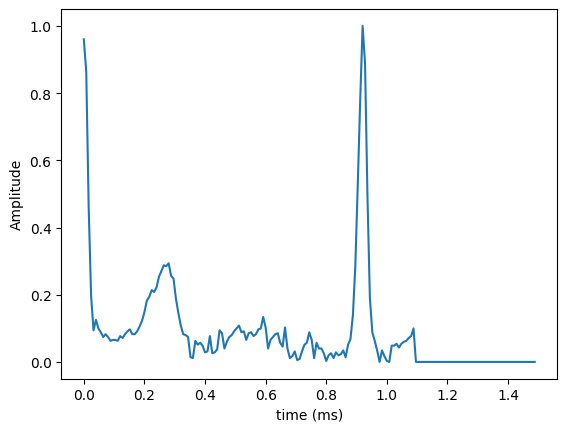

In [ ]:
x = np.arange(0, 187)*8/1000
plt.plot(x,train_data.iloc[0][:-1])
plt.xlabel("time (ms)")
plt.ylabel("Amplitude");

Now let's create two variables X_train,y_train that respectively contain the ECG and the target data

In [ ]:
train_data.columns = range(188)

In [ ]:
X_train = train_data.drop(187,axis=1)
y_train = train_data[187]

Let's check that everything works fine

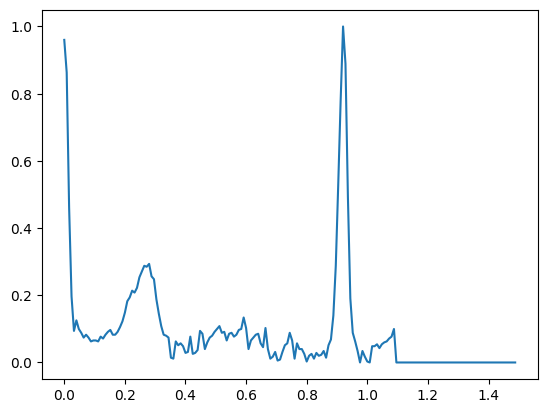

In [ ]:
plt.plot(x,X_train.iloc[0]);

In [ ]:
y_train

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
87548    4.0
87549    4.0
87550    4.0
87551    4.0
87552    4.0
Name: 187, Length: 87553, dtype: float64

### Statistical analysis about our target

Our target data has 5 categories:

* N
* S
* V
* F
* Q

N corresponds to these categories:

* Normal
* Left/Right bundle branch block
* Atrial escape
* Nodal escape

S corresponds to these categories:

* Atrial premature
* Aberrant atrial premature
* Nodal premature
* Supra-ventricular premature

V corresponds to these categories:

* Premature ventricular contraction
* Ventricular escape

F corresponds to this category:

* Fusion of ventricular and normal

Q corresponds to these categories:

* Paced
* Fusion of paced and normal
* Unclassifiable

The first thing we are going to do is to see the distribution of our categories in the target data. To do that we will plot a pie chart representing this distribution

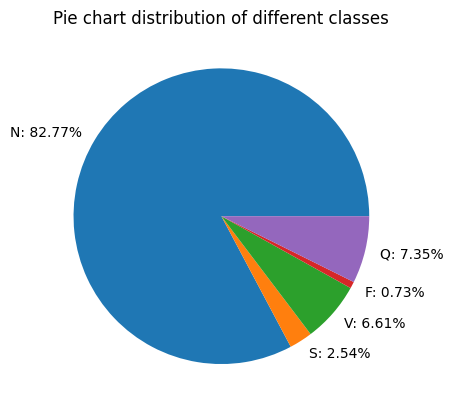

In [ ]:
categories = list(range(5))
hist = []
percentage = []
total = y_train.count()
for i in categories:
  freq = y_train[y_train==i].count()
  hist.append(freq)
  percentage.append(freq/total*100)
label = ["N","S","V","F","Q"]
labels = []
for l,p in zip(label,percentage):
  labels.append(l+": "+str(p.round(2))+"%")
plt.pie(hist,labels=labels)
plt.title("Pie chart distribution of different classes");

We notice that the N categories represents almost 83% of our dataset, it means that our model can have difficulties with classifying the other, especially if don't have enough data.

In our case, we have

In [ ]:
y_train.count()

87553

87553 ECGs.

This is the same order of size than the MNIST dataset (60 000 train images). But the MNIST categories are perfectly balanced. Therefore this imbalance in our categories may effect greatly the performance of our model.

Now, we can plot an ECG for each category.

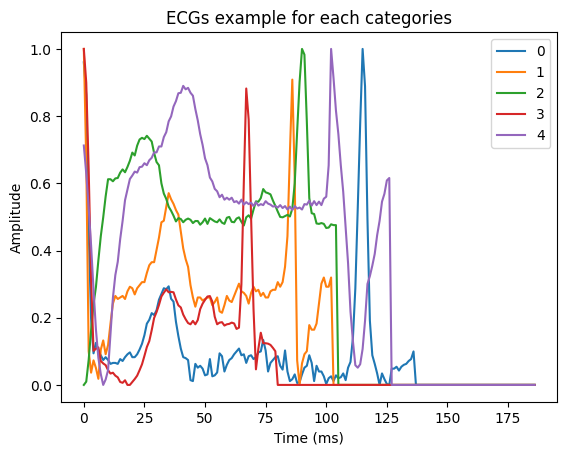

In [ ]:
plt.figure()
for i in categories:
  indexes = y_train[y_train==i].index
  # print(indexes[0])
  plt.plot(X_train.iloc[indexes[0]],label=f"{i}")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("ECGs example for each categories");

Our ECGs looks different according to their categories, which is good news. It means that our model might easily classify our data.

To verify that, let's plot the correlation matrix for each category.

The matrix that you see below is the correlation matrix for all the categories

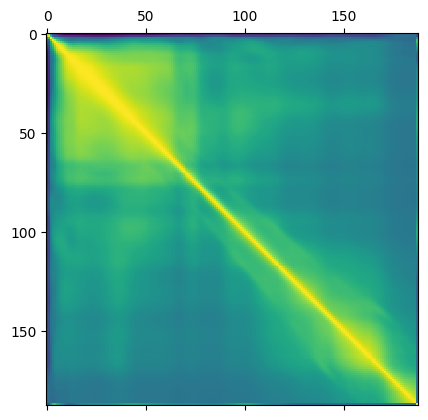

In [ ]:
plt.matshow(train_data.corr())

Now we can plot the correlation matrix for each category.

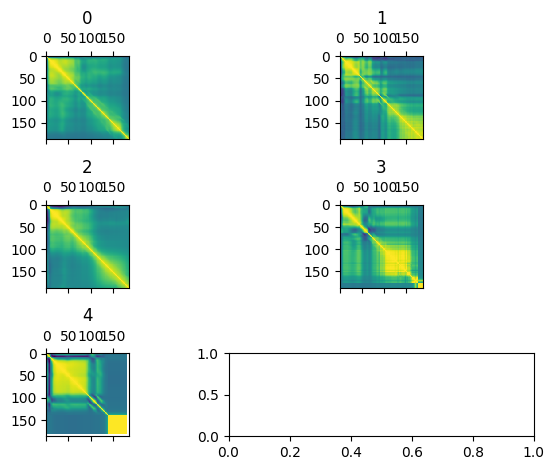

In [ ]:
fig,axs = plt.subplots(3,2)
for i in categories:
  j,k = i//2,i%2
  axs[j][k].matshow(X_train[y_train==i].corr())
  axs[j][k].set_title(f"{i}")
fig.tight_layout()

The correlation matrixes show that ECGs are very different according to the classes they belong.

## Model

In [ ]:
def oneEpoch(x,y,batch_size,nb_batches=None):

    if nb_batches is None:
        nb_batches=len(x)//batch_size

    assert batch_size*nb_batches<=len(x), "pas assez de données"

    shuffle_index=np.random.permutation(len(x))
    x=x[shuffle_index]
    y=y[shuffle_index]

    for i in range(nb_batches):
        yield x[i*batch_size:(i+1)*batch_size],y[i*batch_size:(i+1)*batch_size]

In [ ]:
from tensorflow.keras.utils import to_categorical
x_train = train_data.iloc[:,:186].values
y_train = to_categorical(y_train)

In [ ]:
class Model1(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.layer1 = tf.keras.layers.Conv1D(32,kernel_size=5,activation='relu',padding='same')
    self.dropout = tf.keras.layers.Dropout(0.25)
    self.layer2 = tf.keras.layers.Conv1D(64,kernel_size=5,activation='relu',padding='same')
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(128,activation='relu')
    self.dense2 = tf.keras.layers.Dense(5,activation='softmax')

  @tf.function
  def call(self,x):
    x = tf.expand_dims(x, axis=-1)  # Add an extra dimension
    out = self.layer1(x)
    out = self.dropout(out)
    out = self.layer2(out)
    out = self.dropout(out)
    out = self.flatten(out)
    out = self.dense1(out)
    return self.dense2(out)
model = Model1()
gene = oneEpoch(x_train,y_train,batch_size=2)
x,y=next(gene)
# print(x)
model(x).shape

TensorShape([2, 5])

In [ ]:
model = Model1()
model.compile(
    loss=tf.losses.categorical_crossentropy,
    optimizer=tf.optimizers.Adam(1e-3),
    metrics=['accuracy'])
history = model.fit(x_train,y_train,batch_size=32,epochs=10)

Epoch 1/10
2737/2737 [==============================] - 18s 4ms/step - loss: 0.1754 - accuracy: 0.9520
Epoch 2/10
2737/2737 [==============================] - 12s 4ms/step - loss: 0.0982 - accuracy: 0.9722
Epoch 3/10
2737/2737 [==============================] - 12s 4ms/step - loss: 0.0750 - accuracy: 0.9784
Epoch 4/10
2737/2737 [==============================] - 12s 4ms/step - loss: 0.0622 - accuracy: 0.9816
Epoch 5/10
2737/2737 [==============================] - 11s 4ms/step - loss: 0.0530 - accuracy: 0.9838
Epoch 6/10
2737/2737 [==============================] - 13s 5ms/step - loss: 0.0465 - accuracy: 0.9859
Epoch 7/10
2737/2737 [==============================] - 11s 4ms/step - loss: 0.0407 - accuracy: 0.9873
Epoch 8/10
2737/2737 [==============================] - 12s 4ms/step - loss: 0.0363 - accuracy: 0.9885
Epoch 9/10
2737/2737 [==============================] - 12s 4ms/step - loss: 0.0321 - accuracy: 0.9899
Epoch 10/10
2737/2737 [==============================] - 12s 4ms/step - l

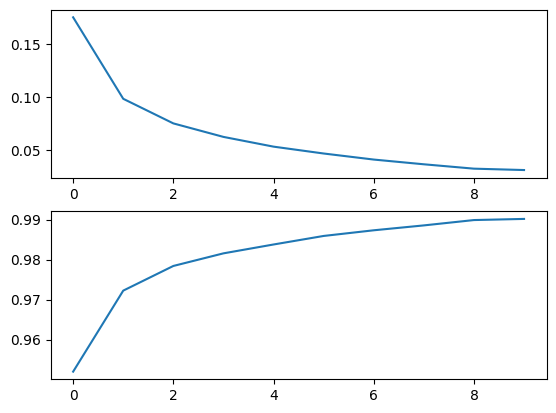

In [ ]:
import matplotlib.pyplot as plt
fig,(ax1,ax2) = plt.subplots(2,1)
ax1.plot(history.history['loss'])
ax2.plot(history.history['accuracy'])

Let's test our model on our test data

In [ ]:
x_test = test_data.iloc[:,:186].values
y_test = to_categorical(test_data.iloc[:,187])

In [ ]:
y_pred = model(x_test)

In [ ]:
loss = tf.reduce_mean((y_pred-y_test)**2)
print(loss)

tf.Tensor(0.0064366404, shape=(), dtype=float32)


In [ ]:
y_pred = np.array(y_pred)

We can check the confusion matrix

In [ ]:
confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))

array([[18018,    55,    31,     6,     7],
       [  127,   415,    12,     1,     1],
       [   62,     2,  1374,     6,     4],
       [   21,     0,    25,   116,     0],
       [   36,     1,    21,     0,  1550]])

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize,
                          title,
                          cmap="jet",
                          precision=3,
                         ):

    y_true=y_true.astype(int)
    y_pred=y_pred.astype(int)
    np.set_printoptions(precision=precision)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    print("Confusion matrix, without normalization:")
    print(cm)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        print(cm)


    fig, ax = plt.subplots(figsize=(8,8))
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.'+str(precision)+'f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "coral")
    fig.tight_layout()

Confusion matrix, without normalization:
[[18018    55    31     6     7]
 [  127   415    12     1     1]
 [   62     2  1374     6     4]
 [   21     0    25   116     0]
 [   36     1    21     0  1550]]
Normalized confusion matrix
[[9.945e-01 3.036e-03 1.711e-03 3.312e-04 3.864e-04]
 [2.284e-01 7.464e-01 2.158e-02 1.799e-03 1.799e-03]
 [4.282e-02 1.381e-03 9.489e-01 4.144e-03 2.762e-03]
 [1.296e-01 0.000e+00 1.543e-01 7.160e-01 0.000e+00]
 [2.239e-02 6.219e-04 1.306e-02 0.000e+00 9.639e-01]]


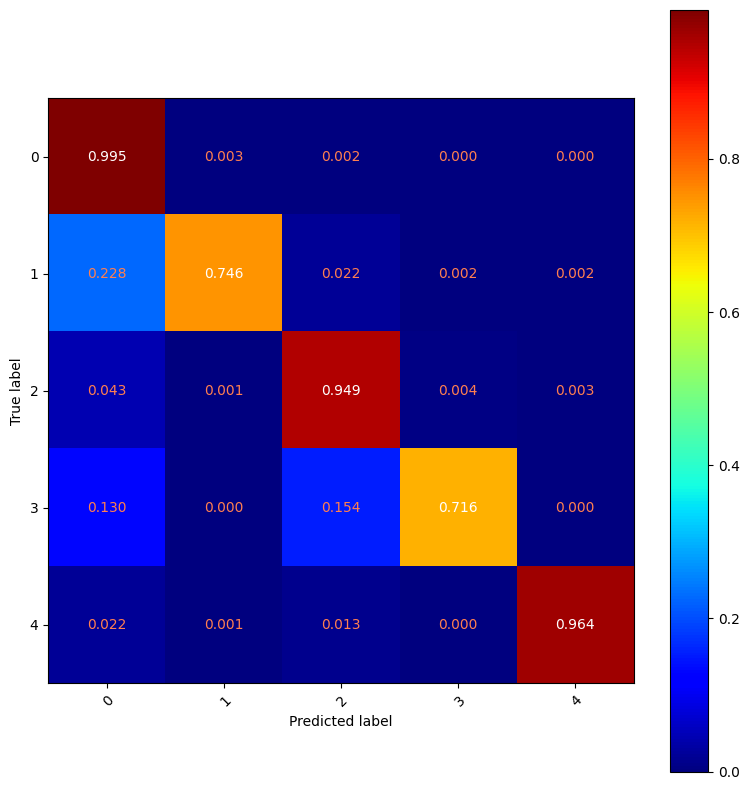

In [ ]:
plot_confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1), np.array([0,1,2,3,4]),True,"confusion matrix")

The results are not bad, but the model can be improved.

Especially on the category S and F.

For the category S, the model can predict N.

And for the cateogory F, the model can predict N and V

A simple thing we can do is to add early-stopping. We stop the training of our model when the validation perfomances start to decrease. To do that, we need to separate our train data into a train set and a validation set.

In [ ]:
x_train.shape

(87553, 186)

In [ ]:
y_train.shape

(87553, 5)

In [ ]:
test = np.concatenate((x_train,y_train),axis=1)
# print(test)
np.random.shuffle(test)
x_train = test[:,:186]
y_train = test[:,186:]

In [ ]:
val_percentage = 0.2
limit = int(x_train.shape[0]*(1-val_percentage))
x_train = test[:limit,:186]
y_train = test[:limit,186:]
x_train.shape
x_val = test[limit:,:186]
y_val = test[limit:,186:]

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model = Model1()
model.compile(
    loss=tf.losses.categorical_crossentropy,
    optimizer=tf.optimizers.Adam(1e-3),
    metrics=['accuracy'])
history = model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_val, y_val),callbacks=[callback])

Epoch 1/10
1752/1752 [==============================] - 12s 6ms/step - loss: 0.2065 - accuracy: 0.9432 - val_loss: 0.1388 - val_accuracy: 0.9609
Epoch 2/10
1752/1752 [==============================] - 11s 6ms/step - loss: 0.1179 - accuracy: 0.9676 - val_loss: 0.1175 - val_accuracy: 0.9685
Epoch 3/10
1752/1752 [==============================] - 10s 6ms/step - loss: 0.0907 - accuracy: 0.9738 - val_loss: 0.1030 - val_accuracy: 0.9714
Epoch 4/10
1752/1752 [==============================] - 9s 5ms/step - loss: 0.0769 - accuracy: 0.9779 - val_loss: 0.0885 - val_accuracy: 0.9766
Epoch 5/10
1752/1752 [==============================] - 11s 6ms/step - loss: 0.0657 - accuracy: 0.9799 - val_loss: 0.0794 - val_accuracy: 0.9782
Epoch 6/10
1752/1752 [==============================] - 11s 6ms/step - loss: 0.0561 - accuracy: 0.9828 - val_loss: 0.0757 - val_accuracy: 0.9787
Epoch 7/10
1752/1752 [==============================] - 9s 5ms/step - loss: 0.0482 - accuracy: 0.9848 - val_loss: 0.0741 - val_accu

Our model is now trained, we can take a look at the history of loss and accuracy for each epochs

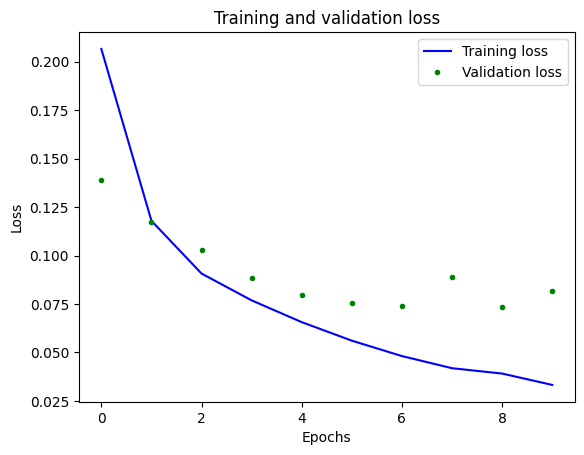

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(range(10), loss, 'b', label='Training loss')
plt.plot(range(10), val_loss, 'g.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

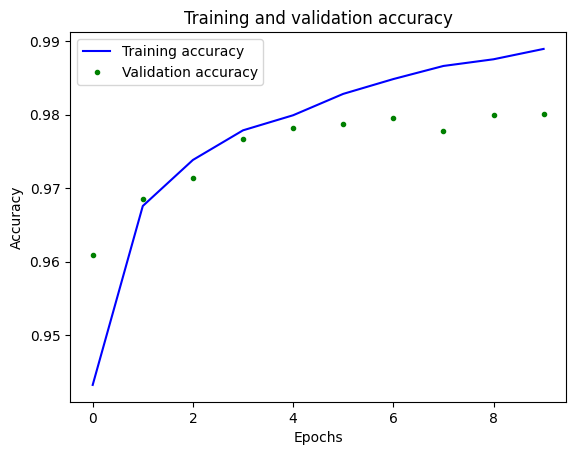

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.plot(range(10), accuracy, 'b', label='Training accuracy')
plt.plot(range(10), val_accuracy, 'g.', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

In [ ]:
y_pred = model(x_test)

Confusion matrix, without normalization:
[[17995    63    47     7     5]
 [  142   401    10     1     2]
 [   65     6  1365     9     3]
 [   35     1    26   100     0]
 [   22     2     5     0  1579]]
Normalized confusion matrix
[[9.933e-01 3.477e-03 2.594e-03 3.864e-04 2.760e-04]
 [2.554e-01 7.212e-01 1.799e-02 1.799e-03 3.597e-03]
 [4.489e-02 4.144e-03 9.427e-01 6.215e-03 2.072e-03]
 [2.160e-01 6.173e-03 1.605e-01 6.173e-01 0.000e+00]
 [1.368e-02 1.244e-03 3.109e-03 0.000e+00 9.820e-01]]


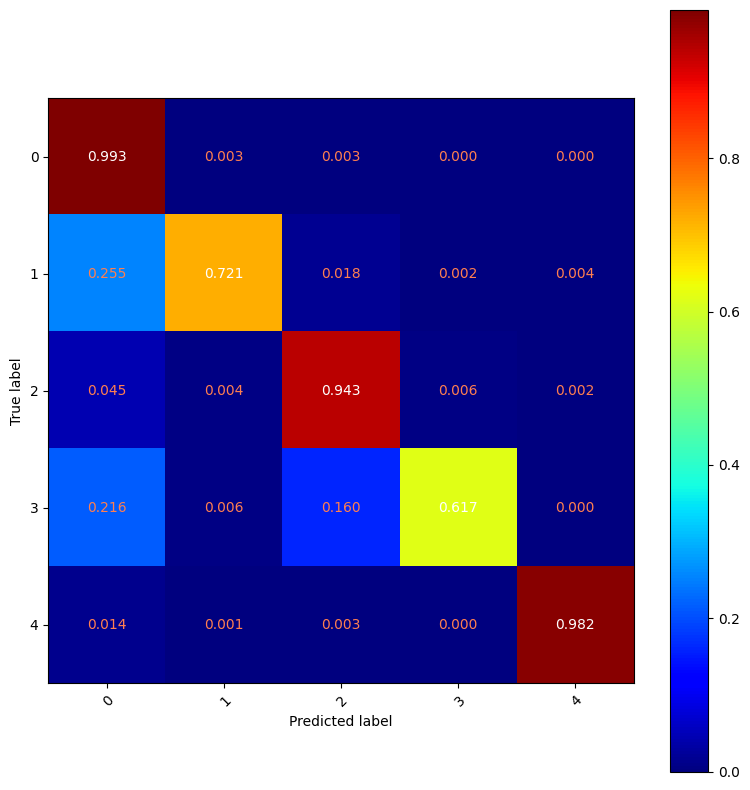

In [ ]:
plot_confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1), np.array([0,1,2,3,4]),True,"confusion matrix")

The performances of the model are not improved with the early stopping. Let's try another model. This time, we will implement the model from [this paper](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-021-01736-y/tables/2)

In [ ]:
class Model2(tf.keras.Model):
  def __init__(self):
    super().__init__()
    # Convolutionnal layer 32
    self.conv32_1 = tf.keras.layers.Conv1D(32,kernel_size=5,activation='relu',padding='same')
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.conv32_2 = tf.keras.layers.Conv1D(32,kernel_size=5,activation='relu',padding='same')
    self.batch_norm2 = tf.keras.layers.BatchNormalization()
    self.conv32_3 = tf.keras.layers.Conv1D(32,kernel_size=5,activation='relu',padding='same')
    self.batch_norm3 = tf.keras.layers.BatchNormalization()
    self.conv32_4 = tf.keras.layers.Conv1D(32,kernel_size=5,activation='relu',padding='same')
    self.batch_norm4 = tf.keras.layers.BatchNormalization()
    self.conv32_5 = tf.keras.layers.Conv1D(32,kernel_size=5,activation='relu',padding='same')
    self.batch_norm5 = tf.keras.layers.BatchNormalization()
    self.conv32_6 = tf.keras.layers.Conv1D(32,kernel_size=5,activation='relu',padding='same')
    self.batch_norm6 = tf.keras.layers.BatchNormalization()
    self.conv32_7 = tf.keras.layers.Conv1D(32,kernel_size=5,activation='relu',padding='same')
    self.batch_norm7 = tf.keras.layers.BatchNormalization()
    self.conv32_8 = tf.keras.layers.Conv1D(32,kernel_size=5,activation='relu',padding='same')
    self.batch_norm8 = tf.keras.layers.BatchNormalization()

    # Dropout layer
    self.dropout = tf.keras.layers.Dropout(0.25)

    # Convolutionnal layer 64
    self.conv64_1 = tf.keras.layers.Conv1D(64,kernel_size=5,activation='relu',padding='same')
    self.batch_norm9 = tf.keras.layers.BatchNormalization()
    self.conv64_2 = tf.keras.layers.Conv1D(64,kernel_size=5,activation='relu',padding='same')
    self.batch_norm10 = tf.keras.layers.BatchNormalization()
    self.conv64_3 = tf.keras.layers.Conv1D(64,kernel_size=5,activation='relu',padding='same')
    self.batch_norm11 = tf.keras.layers.BatchNormalization()
    self.conv64_4 = tf.keras.layers.Conv1D(64,kernel_size=5,activation='relu',padding='same')
    self.batch_norm12 = tf.keras.layers.BatchNormalization()
    self.conv64_5 = tf.keras.layers.Conv1D(64,kernel_size=5,activation='relu',padding='same')
    self.batch_norm13 = tf.keras.layers.BatchNormalization()
    self.conv64_6 = tf.keras.layers.Conv1D(64,kernel_size=5,activation='relu',padding='same')
    self.batch_norm14 = tf.keras.layers.BatchNormalization()
    self.conv64_7 = tf.keras.layers.Conv1D(64,kernel_size=5,activation='relu',padding='same')
    self.batch_norm15 = tf.keras.layers.BatchNormalization()
    self.conv64_8 = tf.keras.layers.Conv1D(64,kernel_size=5,activation='relu',padding='same')
    self.batch_norm16 = tf.keras.layers.BatchNormalization()

    # Convolutionnal layer 128
    self.conv128_1 = tf.keras.layers.Conv1D(128,kernel_size=5,activation='relu',padding='same')
    self.batch_norm17 = tf.keras.layers.BatchNormalization()
    self.conv128_2 = tf.keras.layers.Conv1D(128,kernel_size=5,activation='relu',padding='same')
    self.batch_norm18 = tf.keras.layers.BatchNormalization()
    self.conv128_3 = tf.keras.layers.Conv1D(128,kernel_size=5,activation='relu',padding='same')
    self.batch_norm19 = tf.keras.layers.BatchNormalization()
    self.conv128_4 = tf.keras.layers.Conv1D(128,kernel_size=5,activation='relu',padding='same')
    self.batch_norm20 = tf.keras.layers.BatchNormalization()
    self.conv128_5 = tf.keras.layers.Conv1D(128,kernel_size=5,activation='relu',padding='same')
    self.batch_norm21 = tf.keras.layers.BatchNormalization()
    self.conv128_6 = tf.keras.layers.Conv1D(128,kernel_size=5,activation='relu',padding='same')
    self.batch_norm22 = tf.keras.layers.BatchNormalization()
    self.conv128_7 = tf.keras.layers.Conv1D(128,kernel_size=5,activation='relu',padding='same')
    self.batch_norm23 = tf.keras.layers.BatchNormalization()
    self.conv128_8 = tf.keras.layers.Conv1D(128,kernel_size=5,activation='relu',padding='same')
    self.batch_norm24 = tf.keras.layers.BatchNormalization()

    self.flatten = tf.keras.layers.Flatten()
    self.bilstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True))
    self.bilstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))
    self.dense1 = tf.keras.layers.Dense(128,activation='relu')
    self.dense2 = tf.keras.layers.Dense(64,activation='relu')
    self.dense3 = tf.keras.layers.Dense(32,activation='relu')
    self.dense4 = tf.keras.layers.Dense(5,activation='softmax')

  @tf.function
  def call(self,x):
    x = tf.expand_dims(x, axis=-1)  # Add an extra dimension

    # Conv layers 32
    out = self.conv32_1(x)
    out = self.batch_norm1(out)
    out = self.conv32_2(x)
    out = self.batch_norm2(out)
    out = self.dropout(out)
    out = self.conv32_3(x)
    out = self.batch_norm3(out)
    out = self.conv32_4(x)
    out = self.batch_norm4(out)
    out = self.dropout(out)
    out = self.conv32_5(x)
    out = self.batch_norm5(out)
    out = self.conv32_6(x)
    out = self.batch_norm6(out)
    out = self.dropout(out)
    out = self.conv32_7(x)
    out = self.batch_norm7(out)
    out = self.conv32_8(x)
    out = self.batch_norm8(out)
    out = self.dropout(out)

    # Conv layer 64
    out = self.conv64_1(x)
    out = self.batch_norm9(out)
    out = self.conv64_2(x)
    out = self.batch_norm10(out)
    out = self.dropout(out)
    out = self.conv64_3(x)
    out = self.batch_norm11(out)
    out = self.conv64_4(x)
    out = self.batch_norm12(out)
    out = self.dropout(out)
    out = self.conv64_5(x)
    out = self.batch_norm13(out)
    out = self.conv64_6(x)
    out = self.batch_norm14(out)
    out = self.dropout(out)
    out = self.conv64_7(x)
    out = self.batch_norm15(out)
    out = self.conv64_8(x)
    out = self.batch_norm16(out)
    out = self.dropout(out)

    # Conv layer 128
    out = self.conv128_1(x)
    out = self.batch_norm17(out)
    out = self.conv128_2(x)
    out = self.batch_norm18(out)
    out = self.dropout(out)
    out = self.conv128_3(x)
    out = self.batch_norm19(out)
    out = self.conv128_4(x)
    out = self.batch_norm20(out)
    out = self.dropout(out)
    out = self.conv128_5(x)
    out = self.batch_norm21(out)
    out = self.conv128_6(x)
    out = self.batch_norm22(out)
    out = self.dropout(out)
    out = self.conv128_7(x)
    out = self.batch_norm23(out)
    out = self.conv128_8(x)
    out = self.batch_norm24(out)
    out = self.dropout(out)

    # Flatten
    # out = self.flatten(out)

    # BILSTM layers
    out = self.bilstm1(out)
    out = self.bilstm2(out)

    # Dense layers
    out = self.dense1(out)
    out = self.dense2(out)
    out = self.dense3(out)
    return self.dense4(out)
model = Model2()
gene = oneEpoch(x_train,y_train,batch_size=2)
x,y=next(gene)
# print(x)
model(x).shape

TensorShape([2, 5])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model = Model2()
model.compile(
    loss=tf.losses.categorical_crossentropy,
    optimizer=tf.optimizers.Adam(1e-3),
    metrics=['accuracy'])
history = model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_val, y_val),callbacks=[callback])

Epoch 1/10


2189/2189 [==============================] - 103s 40ms/step - loss: 0.2399 - accuracy: 0.9365 - val_loss: 0.1551 - val_accuracy: 0.9568
Epoch 2/10
2189/2189 [==============================] - 83s 38ms/step - loss: 0.1437 - accuracy: 0.9592 - val_loss: 0.1142 - val_accuracy: 0.9676
Epoch 3/10
2189/2189 [==============================] - 84s 38ms/step - loss: 0.1164 - accuracy: 0.9666 - val_loss: 0.1181 - val_accuracy: 0.9652
Epoch 4/10
2189/2189 [==============================] - 83s 38ms/step - loss: 0.1018 - accuracy: 0.9712 - val_loss: 0.1023 - val_accuracy: 0.9728
Epoch 5/10
2189/2189 [==============================] - 84s 38ms/step - loss: 0.0926 - accuracy: 0.9742 - val_loss: 0.0932 - val_accuracy: 0.9734
Epoch 6/10
2189/2189 [==============================] - 84s 38ms/step - loss: 0.0838 - accuracy: 0.9761 - val_loss: 0.0895 - val_accuracy: 0.9734
Epoch 7/10
2189/2189 [==============================] - 87s 40ms/step - loss: 0.0791 - accuracy: 0.9775 - val_loss: 0.0741 - val_accur

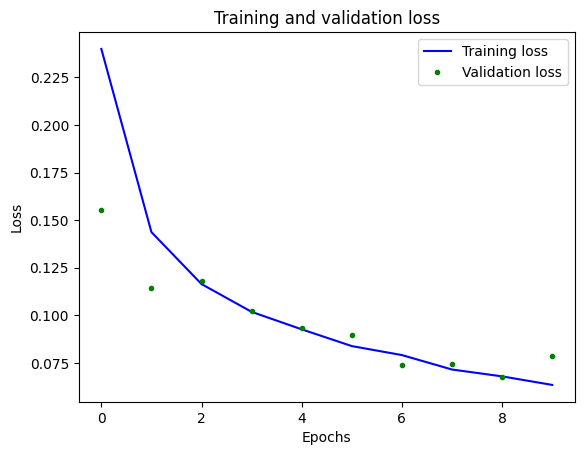

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(range(10), loss, 'b', label='Training loss')
plt.plot(range(10), val_loss, 'g.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

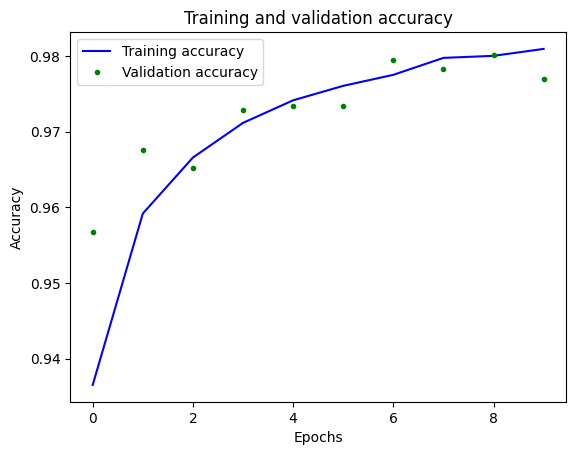

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.plot(range(10), accuracy, 'b', label='Training accuracy')
plt.plot(range(10), val_accuracy, 'g.', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

In [ ]:
x_test = test_data.iloc[:,:186].values
y_test = to_categorical(test_data.iloc[:,187])

In [ ]:
test = np.concatenate((x_test,y_test),axis=1)
# print(test)
np.random.shuffle(test)
x_test = test[:,:186]
y_test = test[:,186:]

In [ ]:
x_test1 = x_test[:5000,:]
y_test1 = y_test[:5000,:]
y_pred = model(x_test1)

Confusion matrix, without normalization:
[[4112   20    9    3   12]
 [  36   81    3    1    0]
 [  13    0  320    3    1]
 [   8    0    4   19    0]
 [   3    0    3    0  349]]
Normalized confusion matrix
[[9.894e-01 4.812e-03 2.166e-03 7.218e-04 2.887e-03]
 [2.975e-01 6.694e-01 2.479e-02 8.264e-03 0.000e+00]
 [3.858e-02 0.000e+00 9.496e-01 8.902e-03 2.967e-03]
 [2.581e-01 0.000e+00 1.290e-01 6.129e-01 0.000e+00]
 [8.451e-03 0.000e+00 8.451e-03 0.000e+00 9.831e-01]]


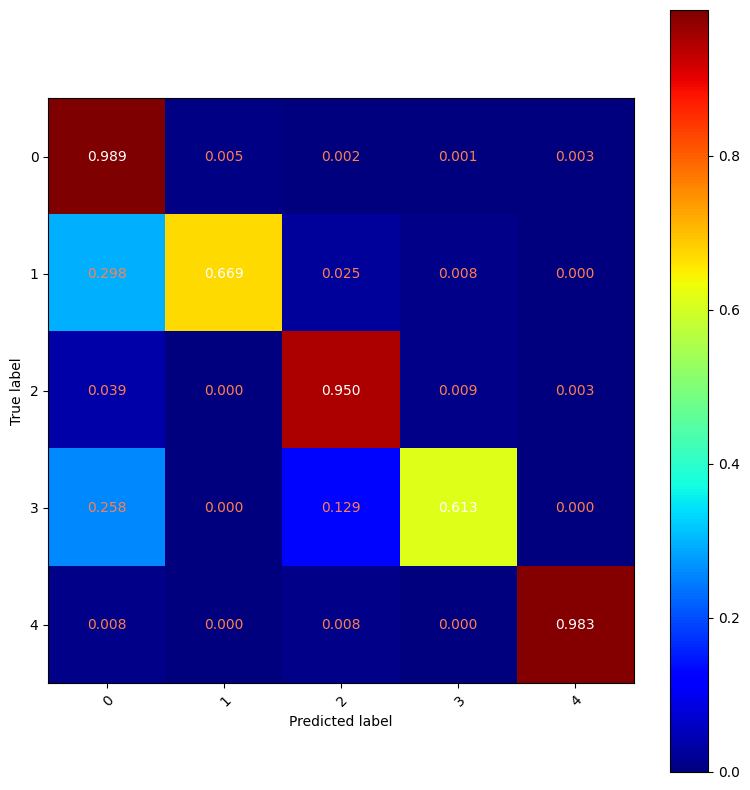

In [ ]:
plot_confusion_matrix(np.argmax(y_test1,axis=1),np.argmax(y_pred,axis=1), np.array([0,1,2,3,4]),True,"confusion matrix")

Our model has still difficulties to detect the category S and F. But, according to the history of loss and accuracy, it is better than the previous model.

Indeed the loss of the validation set is almost identical to the loss of the training set. Which means that our model isn't in overfitting contrarly to the first model.

## Conclusion

We made a model that is able to classify ECGs, but has with some categories.

The main reason is the lack of data for these categories. Indeed, as we saw in the pie chart the category S and F represents in total 3% of the dataset.

If we gathered more data, we could build a model that is accurate on these categories